# Graph Setup

The following notebook will create 2 data sets. One data set will include the edge list for our social network graph. The other data set will include node attributes.

In [39]:
#Import libraries
from pyspark.sql.functions import explode, col, size,  array_except, lit, broadcast, concat, sort_array, concat_ws
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [40]:
#Run necessary notebooks
%run Social_Networking_Project/Data-Retrieval.ipynb

## Subset User to Smaller Dataframe

In [41]:
user = user.select("user_id", "friends", size("friends").alias("friend_count"))

In [42]:
#Add to this to remove more users and subset graph data
user = user.filter((col('friend_count') >= 128))
user = user.select("user_id", "friends").cache()

In [43]:
user.limit(5).toPandas()

,user_id,friends
0,qVc8ODYU5SZjKXVBgXdI7w,"[NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8q..."
1,j14WgRoU_-2ZE1aw1dXrJg,"[ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0..."
2,2WnXYQFK0hXEoTxPtV2zvg,"[LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgy..."
3,SZDeASXq7o05mMNLshsdIA,"[enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74V..."
4,q_QQ5kBBwlCcbL1s4NVK3g,"[xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWt..."


In [44]:
user.count()

250261

## Create Edgelist

In [45]:
edgelist_df = user.select(user.user_id, explode(user.friends).alias('friend_id'))
edgelist_df = edgelist_df.filter((edgelist_df.user_id != '') & (edgelist_df.friend_id != ''))
edgelist_df = edgelist_df.dropDuplicates(['user_id', 'friend_id'])
edgelist_df = edgelist_df.withColumnRenamed("user_id", "source") \
                         .withColumnRenamed("friend_id", "target").cache()

# Sort the values of "source" and "target" columns within an array
sorted_values = sort_array(array([col("source"), col("target")]))

# Concatenate the sorted values with "_" delimiter to create a new column "sorted_pair"
edgelist_df = edgelist_df.withColumn("sorted_pair", concat_ws("_", sorted_values))

# Drop duplicates based on the sorted source and target IDs
edgelist_df = edgelist_df.dropDuplicates(["sorted_pair"])

# Drop the temporary "sorted_pair" column
edgelist_df = edgelist_df.drop("sorted_pair")

In [46]:
edgelist_df.limit(5).toPandas()

,source,target
0,---1lKK3aKOuomHnwAkAow,2dmmcoVBtuRslsnrQmou-w
1,---1lKK3aKOuomHnwAkAow,ARxU6bQVS5_0BMt_S3b6Pw
2,---1lKK3aKOuomHnwAkAow,P8f082TQp9D9Bz67bvcRYQ
3,---1lKK3aKOuomHnwAkAow,S6fNDUu3zafkBpdQ-Z6ftg
4,---1lKK3aKOuomHnwAkAow,kRNvuO4vmX1aS6iFfzYIWg


In [47]:
#Need to subset this still
edgelist_df.count()

73249838

## Subset Edgelist Dataframe to only Users within dataframe

In [48]:
user_to_keep_array = user.select("user_id")

In [49]:
broadcast_user_to_keep_array = broadcast(user_to_keep_array)

In [50]:
broadcast_user_to_keep_array.count()

250261

In [51]:
# Perform an inner join to mark the edges to be removed
edgelist_df = edgelist_df.join(
    broadcast_user_to_keep_array,
    edgelist_df.target == broadcast_user_to_keep_array.user_id,
    "inner"
)
edgelist_df = edgelist_df.drop("user_id").cache()

In [68]:
edgelist_df.select(col('source').alias('node')).union(edgelist_df.select(col('target').alias('node'))).distinct().count()

248140

In [52]:
edgelist_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- target: string (nullable = true)



In [53]:
edgelist_df.count()

4220898

In [69]:
#Percentage of edges
total_possible_edges = 248140*(248140-1)/2
num_edges = 4220898
print("Percentage of edges in the adjacency matrix: {:.2f}%".format(((num_edges/total_possible_edges)*100)))

Percentage of edges in the adjacency matrix: 0.01%


In [55]:
reverse_edges = edgelist_df.select(col('target').alias('source'), col('source').alias('target'))
undirected_edges = edgelist_df.union(reverse_edges)

In [56]:
undirected_edges.count()

8441796

In [57]:
#write edgelist to a parquet file

# Path to the folder containing Parquet partitions
edges_single = f'{proj_directory}/edges_single.parquet'
edges_double = f'{proj_directory}/edges_double.parquet'

# Write DataFrame to a single Parquet file
edgelist_df.write.parquet(edges_single, mode="overwrite")
undirected_edges.write.parquet(edges_double, mode="overwrite")

## Obtain Friend Distribution Count

In [58]:
#Read in the parquet file
edges = spark.read.parquet(f"{proj_directory}/edges_single.parquet")
edges_double = spark.read.parquet(f"{proj_directory}/edges_double.parquet")
edges.limit(10).show()

+--------------------+--------------------+
|              source|              target|
+--------------------+--------------------+
|---2PmXbF47D870st...|QksQOS03Dy38AQ3BJ...|
|7an-zIbFKvGxjpeNN...|--2vR0DIsmQ6WfcSz...|
|--2vR0DIsmQ6WfcSz...|Ariwz06at3CtbWZM-...|
|--2vR0DIsmQ6WfcSz...|DwaaafwryFbW7C4E1...|
|EiwxlbR8fb68lMgEX...|--2vR0DIsmQ6WfcSz...|
|ZFICOFsXYo5I9_0UP...|--2vR0DIsmQ6WfcSz...|
|--2vR0DIsmQ6WfcSz...|_9hHq2zFMMhfsnqzk...|
|RBl0Kv_OMdJcfNCph...|--56mD0sm1eOogphi...|
|--56mD0sm1eOogphi...|WV3rTWQeEDBJeVelL...|
|f-iREBx-5CznQjIMW...|--56mD0sm1eOogphi...|
+--------------------+--------------------+



In [59]:
edges.select(col('source').alias('node')).union(edges.select(col('target').alias('node'))).distinct().count()

248140

In [60]:
edges.count()

4220898

In [61]:
edges_double.select(col('source').alias('node')).union(edges_double.select(col('target').alias('node'))).distinct().count()

248140

In [62]:
edges_double.count()

8441796

In [63]:
# Handle both target and source 
# Combine source and target columns into a single column
all_users = edges.select(col("source").alias("user")).union(edges.select(col("target").alias("user")))

# Count occurrences of each user
friend_counts = all_users.groupBy("user").count()

friend_counts.limit(5).toPandas()

,user,count
0,I36gCt3wR-pu-zNzghNYcA,14
1,o-MqFF5GrUnDAM2TN8KE1w,14
2,kFTv7S3SN5u9kLWP65m5Dg,91
3,0b3FXt-EgiwMvS4scwBKeA,578
4,0r4_-ol2FoAOk8Tsx4qcig,99


In [64]:
friend_counts.orderBy(col("count").desc()).limit(10).show()

+--------------------+-----+
|                user|count|
+--------------------+-----+
|Oi1qbcz2m2SnwUezt...| 5415|
|YttDgOC9AlM4HcAlD...| 3974|
|ZIOCmdFaMIF56FR-n...| 3833|
|xirjSwnrFjF87rYT9...| 3440|
|yLW8OrR8Ns4X1oXJm...| 3405|
|XaMwHlRaUfsSjBewV...| 3269|
|JjXuiru1_ONzDkYVr...| 3266|
|mV4lknblF-zOKSF8n...| 3255|
|9aPhTC34PILldShZH...| 3034|
|8lEywHSvti2UjFP8O...| 3018|
+--------------------+-----+



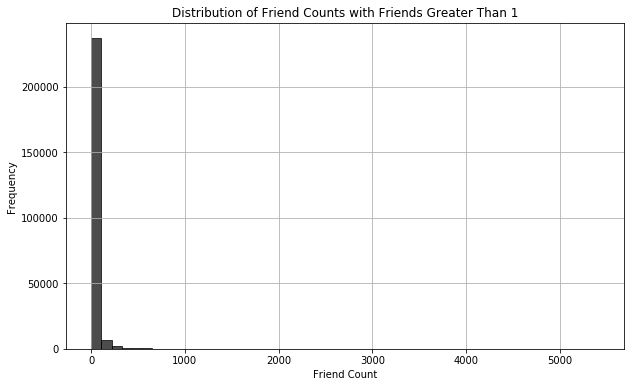

In [65]:
#Distribution of friend counts with more than 1 friend
friend_count_pd = friend_counts.select("count").toPandas()
# Plotting the distribution of friend counts
plt.figure(figsize=(10, 6))
plt.hist(friend_count_pd["count"], bins=50, edgecolor='k', alpha=0.7, color = "black")
plt.title('Distribution of Friend Counts with Friends Greater Than 1')
plt.xlabel('Friend Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("Social_Networking_Project/Images/friend_distribution.png")
plt.show()

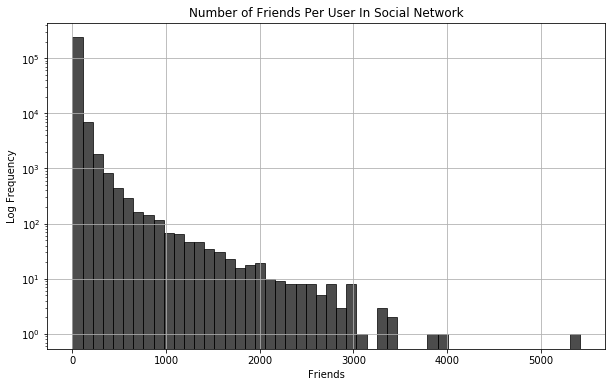

In [66]:
plt.figure(figsize=(10, 6))
plt.hist(friend_count_pd["count"], bins=50, edgecolor='k', alpha=0.7, color='black')
plt.title('Number of Friends Per User In Social Network')
plt.xlabel('Friends')
plt.ylabel('Log Frequency')
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.grid(True)
plt.savefig("Social_Networking_Project/Images/friend_distribution_logscale.png")
plt.show()

In [67]:
stats = friend_count_pd["count"].describe()
for stat,value in stats.items():
    print(f"{stat}: {value}")

count: 248140.0
mean: 34.020294994761024
std: 91.49003586869362
min: 1.0
25%: 8.0
50%: 16.0
75%: 33.0
max: 5415.0
